# Custom Reward

In [3]:
import numpy as np
import pandas as pd
import time
import os
import csv
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import RewardFunction
from citylearn.data import DataSet,ZERO_DIVISION_PLACEHOLDER

#from agents.user_agent import SubmissionAgent
#from rewards.user_reward import SubmissionReward
from stable_baselines3.sac import SAC
from stable_baselines3.ppo import PPO
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

from tqdm import tqdm
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [4]:
class WrapperEnv:
    """
    Env to wrap provide Citylearn Env data without providing full env
    Preventing attribute access outside of the available functions
    """
    def __init__(self, env_data):
        self.observation_names = env_data['observation_names']
        self.action_names = env_data['action_names']
        self.observation_space = env_data['observation_space']
        self.action_space = env_data['action_space']
        self.time_steps = env_data['time_steps']
        self.seconds_per_time_step = env_data['seconds_per_time_step']
        self.random_seed = env_data['random_seed']
        self.buildings_metadata = env_data['buildings_metadata']
        self.episode_tracker = env_data['episode_tracker']
    
    def get_metadata(self):
        return {'buildings': self.buildings_metadata}

def create_citylearn_env(config, reward_function):
    env = CityLearnEnv(config.SCHEMA, reward_function=reward_function)

    env_data = dict(
        observation_names = env.observation_names,
        action_names = env.action_names,
        observation_space = env.observation_space,
        action_space = env.action_space,
        time_steps = env.time_steps,
        random_seed = None,
        episode_tracker = None,
        seconds_per_time_step = None,
        buildings_metadata = env.get_metadata()['buildings']
    )

    wrapper_env = WrapperEnv(env_data)
    return env, wrapper_env


def update_power_outage_random_seed(env: CityLearnEnv, random_seed: int) -> CityLearnEnv:
    """Update random seed used in generating power outage signals.
    
    Used to optionally update random seed for stochastic power outage model in all buildings.
    Random seeds should be updated before calling :py:meth:`citylearn.citylearn.CityLearnEnv.reset`.
    """

    for b in env.buildings:
        b.stochastic_power_outage_model.random_seed = random_seed

    return env

In [5]:
class Config:
    data_dir = './data/'
    SCHEMA = os.path.join(data_dir, 'schemas/warm_up/schema.json')
    num_episodes = 1
    
config = Config()

# Custom reward

In [6]:
from citylearn.reward_function import RewardFunction
from citylearn.reward_function import ComfortReward, SolarPenaltyReward
from citylearn.data import DataSet
from typing import Any, List, Mapping, Union, Tuple
from citylearn.data import ZERO_DIVISION_PLACEHOLDER

In [7]:
class CustomReward(RewardFunction):
    """Calculates custom user-defined multi-agent reward.

    Reward is the :py:attr:`net_electricity_consumption_emission`
    for entire district if central agent setup otherwise it is the
    :py:attr:`net_electricity_consumption_emission` each building.
    
    Adding also carbon intensity
    consommation d'electricite
    intensite lumineuse

    Parameters
    ----------
    env_metadata: Mapping[str, Any]:
        General static information about the environment.
        env_metadata: Mapping[str, Any]:
        General static information about the environment.
    band: float, default = 2.0
        Setpoint comfort band (+/-).
    lower_exponent: float, default = 2.0
        Penalty exponent for when in cooling mode but temperature is above setpoint upper
        boundary or heating mode but temperature is below setpoint lower boundary.
    higher_exponent: float, default = 3.0
        Penalty exponent for when in cooling mode but temperature is below setpoint lower
        boundary or heating mode but temperature is above setpoint upper boundary.
    coefficients: Tuple, default = (1.0, 1.0)
        Coefficents for `citylearn.reward_function.SolarPenaltyReward` and :py:class:`citylearn.reward_function.ComfortReward` values respectively.
    """

    def __init__(self, env_metadata: Mapping[str, Any], band: float = None, lower_exponent: float = None, higher_exponent: float = None, coefficients: Tuple = None):
        self.__functions: List[RewardFunction] = [
            SolarPenaltyReward(env_metadata),
            ComfortReward(env_metadata, band=band, lower_exponent=lower_exponent, higher_exponent=higher_exponent)
        ]
        super().__init__(env_metadata)
        self.coefficients = coefficients
        
    @property
    def coefficients(self) -> Tuple:
        return self.__coefficients
    
    @RewardFunction.env_metadata.setter
    def env_metadata(self, env_metadata: Mapping[str, Any]) -> Mapping[str, Any]:
        RewardFunction.env_metadata.fset(self, env_metadata)

        for f in self.__functions:
            f.env_metadata = self.env_metadata
    
    @coefficients.setter
    def coefficients(self, coefficients: Tuple):
        coefficients = [1.0]*len(self.__functions) if coefficients is None else tuple(coefficients)
        assert len(coefficients) == len(self.__functions), f'{type(self).__name__} needs {len(self.__functions)} coefficients.' 
        self.__coefficients = coefficients

    def calculate(self, observations: List[Mapping[str, Union[int, float]]]) -> List[float]:
        r"""Calculates reward.

        Parameters
        ----------
        observations: List[Mapping[str, Union[int, float]]]
            List of all building observations at current :py:attr:`citylearn.citylearn.CityLearnEnv.
            time_step` that are got from calling :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: List[float]
            Reward for transition to current timestep.
        """
        # coef non utilises
        c1, c2, c3 = 1, 1, 1
        net_electricity_consumption_emission = []
        carbon_intensity = []
        direct_solar_irradiance = []
        diffuse_solar_irradiance = []
        
        # solarpenaltyandcomfortReward
        reward_mix = np.array([f.calculate(observations) for f in self.__functions], dtype='float32')
        reward_mix = reward_mix*np.reshape(self.coefficients, (len(self.coefficients), 1))
        reward_mix = reward_mix.sum(axis=0).tolist()
        
        for o in observations:
            net_electricity_consumption_emission.append(o['net_electricity_consumption'])
            direct_solar_irradiance.append(o['direct_solar_irradiance'])
            diffuse_solar_irradiance.append(o['diffuse_solar_irradiance'])
            carbon_intensity.append(o['carbon_intensity'])
        
        sum_electricity_consumption = [-sum(net_electricity_consumption_emission)]
        building_electricity_consumption = np.array(net_electricity_consumption_emission, dtype=float)*-1
        luminosity = [sum(direct_solar_irradiance)]+[sum(diffuse_solar_irradiance)]
#         luminosity = np.array(luminosity, dtype=float)
#         total_carbon_intensity = [-sum(carbon_intensity)]
#         total_carbon_intensity = np.array(total_carbon_intensity,dtype=float)*-1
        # Convertir la liste en tableau NumPy
        sum_electricity_consumption = np.array(sum_electricity_consumption)

        # Utiliser np.nanmax pour obtenir la valeur maximale
        max_sum_electricity_consumption = np.nanmax(sum_electricity_consumption)

        building_electricity_consumption = np.array(building_electricity_consumption)
        carbon_intensity = np.array(carbon_intensity)
        diffuse_solar_irradiance = np.array(diffuse_solar_irradiance)
        direct_solar_irradiance = np.array(direct_solar_irradiance)
        reward_mix = np.array(reward_mix)
        
        # coef
        c1 = 10.0 # correspond à la consommation electrique, très important
        reward_list = np.sign(building_electricity_consumption)*c1*building_electricity_consumption**2 * np.maximum(0, max_sum_electricity_consumption) - 0.3*carbon_intensity + 0.01*diffuse_solar_irradiance + 0.01*direct_solar_irradiance + reward_mix #+ total_carbon_intensity + luminosity
            
        
        
        if self.central_agent:
            reward = [reward_list.sum()]
#reward = c1 * electricity_cost + c2 * incomfort + c3 * total_carbon_emissions
        else:
            reward = reward_list.tolist()

        return reward

# Pour créer les agents

In [8]:
# CustomReward
res = create_citylearn_env(config, CustomReward)
env = res[0]
wrapper_env = res[1]

In [9]:
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

In [10]:
agent_custom = PPO(policy='MlpPolicy',env=env)

In [11]:
#métrique
def ScoreControl(w1,w2,w3,w4,i,epochTrains):
    ScoreComfort = U[i][epochTrains]
    ScoreEmission = G[i][epochTrains]
    ScoreGrid = R[i][epochTrains] + L[i][epochTrains] + Pd[i][epochTrains] + Pn[i][epochTrains]
    ScoreResilience = M[i][epochTrains] + S[i][epochTrains]
    return w1*ScoreComfort+ w2*ScoreEmission + w3*ScoreGrid + w4*ScoreResilience

In [12]:
# Phase 1
w1_p1 = 0.3
w2_p1 = 0.1
w3_p1 = 0.6
w4_p1 = 0.0

# Phase 2
w1_p2 = 0.3
w2_p2 = 0.1
w3_p2 = 0.3
w4_p2 = 0.3

# initialisation des listes

In [13]:
#Pour chaque kpi, on a 5 listes pour les 5 rewards, contenant chacune les valeurs correspondant à chaque epoch
G = [[],[],[],[],[]]
U = [[],[],[],[],[]]
R = [[],[],[],[],[]]
L = [[],[],[],[],[]]
Pd = [[],[],[],[],[]]
Pn = [[],[],[],[],[]]
M = [[],[],[],[],[]]
S = [[],[],[],[],[]]

#liste de dataframe
kpis = [[],[],[],[],[]]

#ScoreControl pour chaque reward, pour chaque epoch
Score = [[],[],[],[],[]]

# RewardFunc = ['ComfortReward','SolarPenaltyReward','SolarPenaltyAndComfortReward','MARL','IndependentSACReward']
RewardFunc = 'CustomReward'
# RewardFunc = 'ComfortReward'


epochInit = 0
epochEnd = 50

# Training

In [15]:
for epochTrains in tqdm(range(epochInit,epochEnd)):
    agent_custom.learn(total_timesteps=env.time_steps*2)
    agent_custom.save("./models/{}/PPOmodel_{}epoch".format(RewardFunc,epochTrains*2))
    
    kpis[0] = env.evaluate()
    kpis[0] = kpis[0].pivot(index='cost_function',columns='name',values='value')
    
    #carbon emission
    G[0].append(float(kpis[0].loc['carbon_emissions_total','District']))
    #unmet hours
    U[0].append(float(kpis[0].loc['discomfort_proportion','District']))
    #ramping
    R[0].append(float(kpis[0].loc['ramping_average','District']))
    #1 - load factor
    L[0].append(float(kpis[0].loc['daily_one_minus_load_factor_average','District']))
    #daily peak
    Pd[0].append(float(kpis[0].loc['daily_peak_average','District']))
    #all-time peak
    Pn[0].append(float(kpis[0].loc['annual_peak_average','District']))
    #1 - thermal resilience
    M[0].append(float(kpis[0].loc['one_minus_thermal_resilience_proportion','District']))
    #Normalized unserved energy
    S[0].append(float(kpis[0].loc['power_outage_normalized_unserved_energy_total','District']))
    
    #On s'intéresse seulement à la phase 2 pour le calcul du score
    Score[0].append(ScoreControl(w1_p2,w2_p2,w3_p2,w4_p2,0,epochTrains-epochInit))

100%|██████████| 50/50 [37:48<00:00, 45.37s/it]


# Résultats

In [16]:
#liste des scores à chaque epoch pour chaque reward function
print(RewardFunc[0],' :', Score[0])

C  : [2.300724016165453, 2.2876396337648175, 2.267753289284389, 2.352378094782029, 2.3219746341393237, 2.2703445355753753, 2.395414658630164, 2.233183772434139, 2.221299684954476, 2.313955404585349, 2.2458529267370593, 2.255337193304297, 2.2175217525622206, 2.2104531501776665, 2.187563962364551, 2.108978357350446, 2.227097063686781, 2.0642596318044837, 2.06002218504643, 2.248318081746053, 2.2456096924142925, 2.0578744204245494, 2.2494710707396535, 2.288051120242213, 2.111979556159491, 2.227243441517282, 2.2243524545639892, 2.280452375492019, 2.136624049403926, 2.1509970296032512, 2.2605874739436644, 2.1691587207136767, 2.1893607109957673, 2.1427128655095773, 2.170538189605391, 2.1681296005102144, 2.0881984137425738, 2.1757009435885792, 2.273772161347014, 2.193629939328094, 2.196728760248729, 2.223883552928247, 2.3430152456887585, 2.2706706110949813, 2.166651905273112, 2.1972395746689033, 2.2279863780198244, 2.129843370906789, 2.235374189284804, 2.167398969915182]


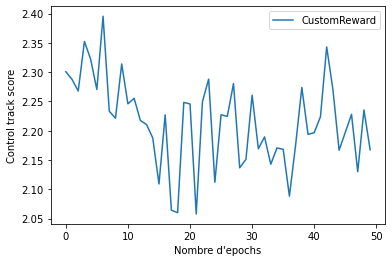

In [18]:
#graphique des scores
plt.plot(Score[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Control track score')
plt.legend()
plt.savefig('Graphique ScoreControl Custom Reward')
plt.show()

In [19]:
#score minimum pour chaque reward function
print(RewardFunc[0],'score minimal atteint a l\'epoch', np.argmin(Score[0]), ':', min(Score[0]))

C score minimal atteint a l'epoch 21 : 2.0578744204245494


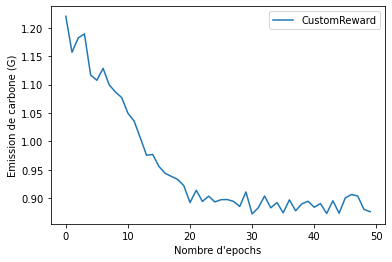

In [20]:
#Graphique de l'emission de carbone (G) pour chaque reward function
#Il s'agit aussi du score d'émission
plt.plot(G[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Emission de carbone (G)')
plt.legend()
plt.savefig('Graphique G Custom Reward')
plt.show()

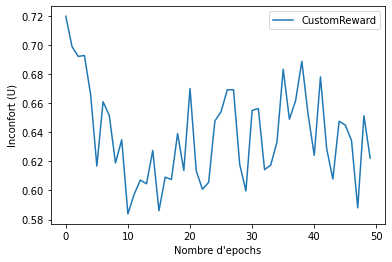

In [21]:
#Graphique de l'inconfort ou heure insatisfaite (U) pour chaque reward function
#Il s'agit aussi du score de confort
plt.plot(U[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Inconfort (U)')
plt.legend()
plt.show()
plt.savefig('Inconfort U Custom Reward')

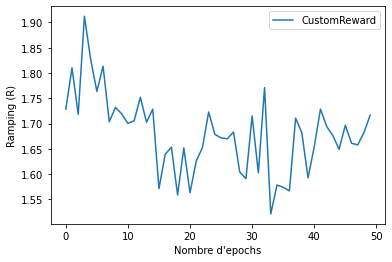

In [22]:
#Graphique du ramping (R) pour chaque reward function
plt.plot(R[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Ramping (R)')
plt.legend()
plt.savefig('Graphique R Custom Reward')
plt.show()

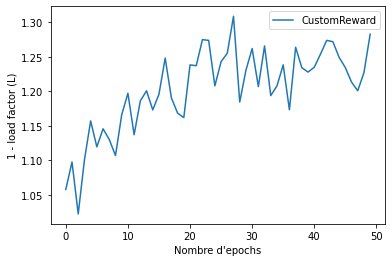

In [23]:
#Graphique de 1-load factor (L) pour chaque reward function
plt.plot(L[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('1 - load factor (L)')
plt.legend()
plt.savefig('Graphique L Custom Reward')
plt.show()

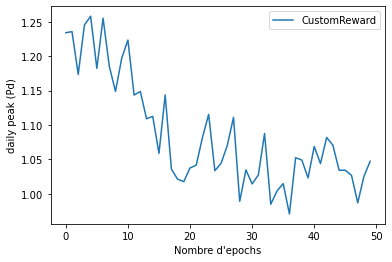

In [24]:
#Graphique de daily peak (Pd) pour chaque reward function
plt.plot(Pd[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('daily peak (Pd)')
plt.legend()
plt.savefig('Graphique Pd Custom Reward')
plt.show()

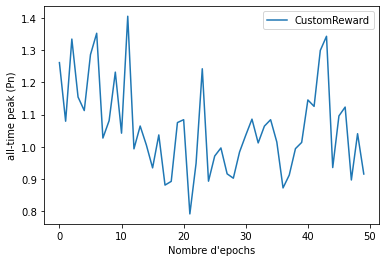

In [25]:
#Graphique de all-time peak (Pn) pour chaque reward function
plt.plot(Pn[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('all-time peak (Pn)')
plt.legend()
plt.savefig('Graphique Pn Custom Reward')
plt.show()

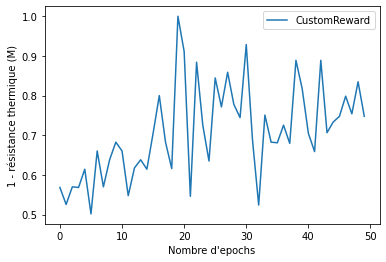

In [26]:
#Graphique de 1 - résistance thermique (M) pour chaque reward function
plt.plot(M[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('1 - résistance thermique (M)')
plt.legend()
plt.savefig('Graphique M Custom Reward')
plt.show()

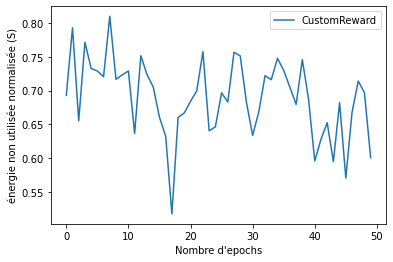

In [27]:
#Graphique d'énergie non utilisée normalisée (S) pour chaque reward function
plt.plot(S[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('énergie non utilisée normalisée (S)')
plt.legend()
plt.savefig('Graphique S Custom Reward')
plt.show()

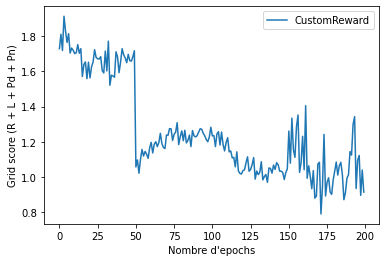

In [28]:
#Graphique du grid score (R + L + Pd + Pn) pour chaque reward function
plt.plot(R[0] + L[0] + Pd[0] + Pn[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Grid score (R + L + Pd + Pn)')
plt.legend()
plt.savefig('Graphique ScoreGrid Custom Reward')
plt.show()

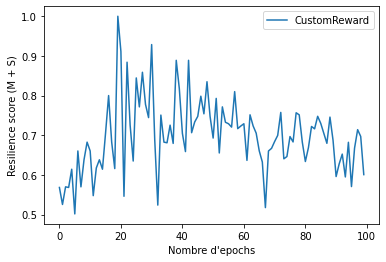

In [29]:
#Graphique du resilience score (M + S) pour chaque reward function
plt.plot(M[0] + S[0],label=RewardFunc)
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Resilience score (M + S)')
plt.legend()
plt.savefig('Graphique ScoreResilience Custom Reward')
plt.show()

# Pour import un agent

In [206]:
env, wrapper_env = create_citylearn_env(config, ComfortReward)

In [5]:
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

In [8]:
agent = PPO('MlpPolicy', env)
agent.load("./models/SolarPenaltyReward/PPOModel_2epoch") #à changer selon l'agent qu'on veut importer
agent.learn(total_timesteps=env.time_steps)

In [9]:
kpis=env.evaluate()
kpis=kpis.pivot(index='cost_function',columns='name',values='value')
kpis

name,Building_1,Building_2,Building_3,District
cost_function,,,,
annual_normalized_unserved_energy_total,0.012804,0.019098,0.021081,0.017661
annual_peak_average,NaN,NaN,NaN,1.262812
carbon_emissions_total,1.223417,1.316120,1.134386,1.224641
cost_total,1.195233,1.303915,1.120391,1.206513
daily_one_minus_load_factor_average,NaN,NaN,NaN,1.067114
daily_peak_average,NaN,NaN,NaN,1.266355
discomfort_delta_average,-5.998705,-2.221172,-1.627210,-3.282362
discomfort_delta_maximum,5.025061,6.766607,5.014055,5.601908
discomfort_delta_minimum,-14.532576,-11.641537,-6.114584,-10.762899


In [10]:
#On prend seulement les valeurs du District
#.loc retourne des tuples, il faut les convertir en float
#carbon emission
G = float(kpis.loc['carbon_emissions_total','District'])
#unmet hours
U = float(kpis.loc['discomfort_proportion','District'])
#ramping
R = float(kpis.loc['ramping_average','District'])
#1 - load factor
L = float(kpis.loc['daily_one_minus_load_factor_average','District'])
#daily peak
Pd = float(kpis.loc['daily_peak_average','District'])
#all-time peak
Pn = float(kpis.loc['annual_peak_average','District'])
#1 - thermal resilience
M = float(kpis.loc['one_minus_thermal_resilience_proportion','District'])
#Normalized unserved energy
S = float(kpis.loc['power_outage_normalized_unserved_energy_total','District'])

In [11]:
def ScoreControl2(w1,w2,w3,w4):
    ScoreComfort = U
    ScoreEmission = G
    ScoreGrid = R + L + Pd + Pn
    ScoreResilience = M + S
    return w1*ScoreComfort+ w2*ScoreEmission + w3*ScoreGrid + w4*ScoreResilience

In [13]:
# Phase 1
w1_p1 = 0.3
w2_p1 = 0.1
w3_p1 = 0.6
w4_p1 = 0.0

# Phase 2
w1_p2 = 0.3
w2_p2 = 0.1
w3_p2 = 0.3
w4_p2 = 0.3

In [15]:
print(ScoreControl2(w1_p2,w2_p2,w3_p2,w4_p2))

2.3520903793268406
